In [140]:
import os

try:
    from dotenv import load_dotenv
except ImportError:
    from pip._internal import main as pip
    pip(['install', 'python-dotenv'])
    from dotenv import load_dotenv

try:
    import psycopg2
except ImportError:
    from pip._internal import main as pip
    pip(['install', 'psycopg2'])
    import psycopg2

try:
    import plotly.graph_objects as go
except ImportError:
    from pip._internal import main as pip
    pip(['install', 'plotly'])
    import plotly.graph_objects as go

import sqlalchemy
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import sklearn
import plotly.express as px
import matplotlib.pyplot as plt

In [26]:
load_dotenv(dotenv_path='//.env')
db = os.getenv('DB')

In [28]:
sql = sqlalchemy.text("""SELECT
	CASE
		WHEN sub_event_type = 'Air/drone strike' THEN 'Drone Strike'
	END type_of_strike,acled.*,ST_Distance(acled.geom::geography,cities.geom::geography) AS distance_to_nearest_city,cities.name AS nearest_city,cities.gn_pop
FROM
	acled
CROSS JOIN LATERAL (
	SELECT name, geom, cities.gn_pop
	FROM cities
	WHERE gn_pop > 0
	ORDER BY cities.geom <-> acled.geom
	LIMIT 1
) cities
WHERE 
country = 'Libya'
AND
year > 2011
AND
year < 2021
AND
sub_event_type = 'Air/drone strike'
AND
	notes ILIKE ALL (ARRAY['%drone%'])

UNION

SELECT
	CASE
		WHEN sub_event_type = 'Air/drone strike' THEN 'Air Strike'
	END type_of_strike, acled.*,ST_Distance(acled.geom::geography,cities.geom::geography) AS distance_to_nearest_city,cities.name AS nearest_city,cities.gn_pop
FROM
acled
CROSS JOIN LATERAL (
	SELECT name, geom, cities.gn_pop
	FROM cities
	WHERE gn_pop > 0
	ORDER BY cities.geom <-> acled.geom
	LIMIT 1
) cities
WHERE
country = 'Libya'
AND
year > 2011
AND
year < 2021
AND
sub_event_type = 'Air/drone strike'
AND
	notes NOT ILIKE ALL (ARRAY['%drone%']) 
ORDER BY event_date""")

## Getting the Data

In [29]:
libya = pd.read_sql_query(sql,db)

## Looking at the data structure

In [30]:
libya.head()

,type_of_strike,data_id,iso,event_id_cnty,event_id_no_cnty,event_date,year,time_precision,event_type,sub_event_type,...,source,source_scale,notes,fatalities,timestamp,iso3,geom,distance_to_nearest_city,nearest_city,gn_pop
0,Air Strike,6744576,434,LBY1055,1055,2012-12-18,2012,1,Explosions/Remote violence,Air/drone strike,...,Magharebia,Regional,A Libyan airstrike destroyed a suspected smugg...,0,1579564002,LBY,0101000020E610000085EB51B81E453740986E1283C02A...,581941.884062,Awjilah,6610.0
1,Drone Strike,6736849,434,LBY1455,1455,2013-10-14,2013,1,Explosions/Remote violence,Air/drone strike,...,Xinhua; Al Jazeera,Regional-International,Between 4-7 Ansar al-Sharia members died in Li...,4,1579563977,LBY,0101000020E6100000BB270F0BB596304068226C787A35...,175.772368,Surt,128123.0
2,Air Strike,6759643,434,LBY1694,1694,2014-01-18,2014,1,Explosions/Remote violence,Air/drone strike,...,Xinhua; WAL News Agency; AFP,National-International,The Libyan army recaptured the Tamenhant base ...,0,1579805276,LBY,0101000020E6100000ECC039234ADB2C40280F0BB5A609...,56762.284874,Birak,39444.0
3,Air Strike,6739044,434,LBY2070,2070,2014-05-17,2014,1,Explosions/Remote violence,Air/drone strike,...,AFP,International,A war plane bombed an Islamist position in the...,0,1579563984,LBY,0101000020E6100000705F07CE192134409E5E29CB100F...,6090.084456,Banghazi,650629.0
4,Air Strike,6736922,434,LBY2105,2105,2014-05-28,2014,1,Explosions/Remote violence,Air/drone strike,...,Libya Al Ahrar; VOA,National-International,Forces loyal to former general Khalifa Haftar ...,0,1579563977,LBY,0101000020E6100000A9A44E4013113440787AA52C4304...,9469.289323,Banghazi,650629.0


In [31]:
libya.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   type_of_strike            1449 non-null   object 
 1   data_id                   1449 non-null   int64  
 2   iso                       1449 non-null   int64  
 3   event_id_cnty             1449 non-null   object 
 4   event_id_no_cnty          1449 non-null   object 
 5   event_date                1449 non-null   object 
 6   year                      1449 non-null   int64  
 7   time_precision            1449 non-null   int64  
 8   event_type                1449 non-null   object 
 9   sub_event_type            1449 non-null   object 
 10  actor1                    1449 non-null   object 
 11  assoc_actor_1             191 non-null    object 
 12  inter1                    1449 non-null   int64  
 13  actor2                    1303 non-null   object 
 14  assoc_ac

In [32]:
libya['type_of_strike'].value_counts()

Air Strike      1400
Drone Strike      49
Name: type_of_strike, dtype: int64

In [33]:
libya['actor1'].value_counts()

Military Forces of Libya (2014-) Haftar Faction                              893
Military Forces of Libya (2016-) Government of National Accord               201
Unidentified Military Forces                                                  58
Pro-Haftar Faction and/or Military Forces of United Arab Emirates (2004-)     53
Military Forces of the United States (2009-2017)                              42
Islamic State (Libya)                                                         42
Military Forces of the United States (2017-2021)                              25
Military Forces of Egypt (2014-)                                              21
Mutiny of Military Forces of Libya (2012-2014)                                19
Military Forces of the United Arab Emirates (2004-)                           14
Operation Libya Dawn                                                          13
Ansar al-Sharia                                                               13
Military Forces of Libya (20

In [34]:
libya.describe()

,data_id,iso,year,time_precision,inter1,inter2,interaction,latitude,longitude,geo_precision,fatalities,timestamp,distance_to_nearest_city,gn_pop
count,1.449000e+03,1449.0,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1.449000e+03,1449.000000,1449.000000
mean,6.924798e+06,434.0,2017.419600,1.013803,1.922705,2.545894,16.797792,31.617950,16.489656,1.186335,1.529331,1.586223e+09,33426.508153,229995.173913
std,2.856617e+05,0.0,1.872836,0.122486,2.239053,2.015684,12.061300,1.677901,3.552001,0.398278,5.059795,1.119428e+07,64311.654793,204579.402449
min,6.713214e+06,434.0,2012.000000,1.000000,1.000000,0.000000,10.000000,21.900000,10.561300,1.000000,0.000000,1.578512e+09,1.100163,3928.000000
25%,6.739569e+06,434.0,2016.000000,1.000000,1.000000,1.000000,11.000000,31.208900,13.216700,1.000000,0.000000,1.579564e+09,868.925586,78782.000000
50%,6.744119e+06,434.0,2017.000000,1.000000,1.000000,3.000000,13.000000,32.117700,15.782700,1.000000,0.000000,1.579564e+09,9469.289323,134358.000000
75%,7.064938e+06,434.0,2019.000000,1.000000,1.000000,3.000000,17.000000,32.746100,20.096100,1.000000,0.000000,1.587417e+09,37393.899699,229398.000000
max,7.712954e+06,434.0,2020.000000,3.000000,8.000000,8.000000,88.000000,33.073700,24.966700,3.000000,90.000000,1.614040e+09,620422.733395,650629.000000


In [35]:
libya.query('type_of_strike == "Air Strike"')['fatalities'].mean()

1.4928571428571429

In [36]:
libya.query('type_of_strike == "Drone Strike"')['fatalities'].mean()

2.5714285714285716

In [37]:
fig = px.box(libya, x="type_of_strike", y="fatalities")
fig.show()

In [38]:
fig = px.scatter_mapbox(libya, lat="latitude", lon='longitude', color="type_of_strike",
                     hover_name="type_of_strike", size="fatalities", zoom=2)
fig.update_layout(mapbox_style="open-street-map")
fig.show()

In [39]:
libya.query('type_of_strike == "Air Strike"')['event_date'].min()

datetime.date(2012, 12, 18)

In [40]:
libya.query('type_of_strike == "Drone Strike"')['event_date'].min()

datetime.date(2013, 10, 14)

In [41]:
drone = libya.query('type_of_strike == "Drone Strike"').groupby('year')['year'].count().reset_index(name='counts')
fig = px.bar(drone,x="year", y='counts')
fig.update_xaxes(dtick='Y1')
fig.show()

In [42]:
air = libya.query('type_of_strike == "Air Strike"').groupby('year')['year'].count().reset_index(name='counts')
fig = px.bar(air,x="year", y='counts')
fig.update_xaxes(dtick='Y1')
fig.show()

In [43]:
both = libya.groupby(['year','type_of_strike'])['type_of_strike'].count().reset_index(name='counts')
fig = px.bar(both,x="year", y='counts',color='type_of_strike')
fig.update_xaxes(dtick='Y1')
fig.update_layout(barmode='group')
fig.show()

In [45]:
libya['event_date'] = pd.to_datetime(libya['event_date'], errors='raise')
libya['day_of_week']=libya['event_date'].dt.day_name()

In [46]:
days = libya.groupby(['day_of_week','type_of_strike'])['type_of_strike'].count().reset_index(name='counts')
fig = px.bar(days,x="day_of_week", y='counts',color='type_of_strike')
fig.update_layout(barmode='group')
fig.show()

In [76]:
libya_labels = libya.drop(libya.columns.difference(['type_of_strike']),1)
libya_clean = libya.drop('type_of_strike', axis=1)

In [77]:
libya_clean['event_date'] = pd.to_datetime(libya_clean['event_date'], errors='raise')
libya_clean['day_of_week']=libya_clean['event_date'].dt.day_name()

In [78]:
libya_clean.columns

Index(['data_id', 'iso', 'event_id_cnty', 'event_id_no_cnty', 'event_date',
       'year', 'time_precision', 'event_type', 'sub_event_type', 'actor1',
       'assoc_actor_1', 'inter1', 'actor2', 'assoc_actor_2', 'inter2',
       'interaction', 'region', 'country', 'admin1', 'admin2', 'admin3',
       'location', 'latitude', 'longitude', 'geo_precision', 'source',
       'source_scale', 'notes', 'fatalities', 'timestamp', 'iso3', 'geom',
       'distance_to_nearest_city', 'nearest_city', 'gn_pop', 'day_of_week'],
      dtype='object')

In [79]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

drop_col = ['data_id','iso','time_precision','geo_precision','timestamp','iso3','notes','source_scale','source','event_type','sub_event_type','event_id_cnty','event_id_no_cnty','geom','location','admin3','admin2','admin3','country','region','event_date','assoc_actor_1','inter1','actor2','assoc_actor_2','inter2','interaction','admin1','nearest_city','day_of_week']

cat_attribs = ['day_of_week','actor1']
#cat_attribs = ['day_of_week']
num_attribs = ['year','latitude','longitude','fatalities','distance_to_nearest_city','gn_pop']

pipeline_scaler = ColumnTransformer([
    ('cat', OneHotEncoder(), cat_attribs),
    ('std_scaler', StandardScaler(), num_attribs)
])

libya_prepared = pipeline_scaler.fit_transform(libya_clean)

In [80]:
feature_names = list(pipeline_scaler.transformers_[0][1].get_feature_names())
for item in num_attribs:
    feature_names.append(item)

In [81]:
print(feature_names)

['x0_Friday', 'x0_Monday', 'x0_Saturday', 'x0_Sunday', 'x0_Thursday', 'x0_Tuesday', 'x0_Wednesday', 'x1_Ansar al-Sharia', 'x1_DPF: Derna Protection Force', 'x1_Islamic State (Libya)', 'x1_Military Forces of Egypt (2014-)', 'x1_Military Forces of France (2012-2017)', 'x1_Military Forces of France (2017-)', 'x1_Military Forces of Israel (2009-)', 'x1_Military Forces of Libya (2012-2014)', 'x1_Military Forces of Libya (2014-) Haftar Faction', 'x1_Military Forces of Libya (2014-) Haftar Faction - Saiqa Forces', 'x1_Military Forces of Libya (2016-) Government of National Accord', 'x1_Military Forces of Turkey (2016-)', 'x1_Military Forces of the United Arab Emirates (2004-)', 'x1_Military Forces of the United States (2009-2017)', 'x1_Military Forces of the United States (2017-2021)', 'x1_Misratah Communal Militia (Libya)', 'x1_Mutiny of Military Forces of Libya (2012-2014)', 'x1_Operation Libya Dawn', 'x1_Operation Sunrise', 'x1_Pro-GNA Faction and/or Military Forces of Turkey (2016-)', 'x1

In [82]:
lable_pipeline = ColumnTransformer([
    ('label_cat', OneHotEncoder(),['type_of_strike'])
])

libya_labels_1hot = lable_pipeline.fit_transform(libya_labels)

In [91]:
lr_x_train, lr_x_test, lr_y_train, lr_y_test = train_test_split(libya_prepared,libya_labels_1hot, test_size=0.3, random_state=42)

In [92]:
lr_x_train.shape

(1014, 37)

In [93]:
lr_y_train.shape

(1014, 2)

In [94]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(lr_x_train,lr_y_train)

LinearRegression()

In [95]:
print("Predictions:",lin_reg.predict(lr_x_train[:25,]))

Predictions: [[ 1.01393481 -0.01393477]
 [ 0.95621058  0.04378942]
 [ 0.99673286  0.00326712]
 [ 0.97036518  0.02963479]
 [ 0.98178372  0.01821635]
 [ 1.00857817 -0.00857812]
 [ 0.97386446  0.02613554]
 [ 0.98066847  0.01933158]
 [ 0.38967644  0.61032354]
 [ 0.98796545  0.01203455]
 [ 0.97111786  0.02888214]
 [ 0.97175713  0.02824283]
 [ 0.92678676  0.07321317]
 [ 0.97103468  0.02896531]
 [ 1.00889174 -0.00889171]
 [ 0.99429326  0.00570677]
 [ 0.90927729  0.09072266]
 [ 0.981786    0.01821399]
 [ 0.97196836  0.02803165]
 [ 1.00722704 -0.00722704]
 [ 1.01295888 -0.01295889]
 [ 1.00328805 -0.003288  ]
 [ 0.906506    0.09349395]
 [ 0.97652474  0.02347527]
 [ 0.9891982   0.01080182]]


In [96]:
print("Labels:",lr_y_train[:25,1])

Labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]


In [97]:
lin_reg.score(lr_x_train,lr_y_train)

0.14111002029140196

In [98]:
from sklearn.metrics import mean_squared_error
strike_predictions = lin_reg.predict(lr_x_train)
lin_mse = mean_squared_error(lr_y_train, strike_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.16444561094743076

## Classifier Set up

In [99]:
libya_labs = libya.drop(libya.columns.difference(['type_of_strike']),1)
libya_class = libya.drop('type_of_strike',axis=1)
libya_class['event_date'] = pd.to_datetime(libya_class['event_date'], errors='raise')
libya_class['day_of_week']=libya_class['event_date'].dt.day_name()

pipeline = ColumnTransformer([
    ('cat', OneHotEncoder(), cat_attribs),
    ('pass', 'passthrough', num_attribs)
])

cleaned = pipeline.fit_transform(libya_class)

lable_pipeline2 = ColumnTransformer([
    ('label_cat', OneHotEncoder(),['type_of_strike'])
])

labels = lable_pipeline2.fit_transform(libya_labs)

X_train, X_test, y_train, y_test = train_test_split(cleaned,labels, test_size=.33, random_state=1)

In [100]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(970, 37) (479, 37) (970, 2) (479, 2)


In [101]:
y_train[:30,1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [104]:
X_train.toarray()[:1]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.01500000e+03,
        3.26904000e+01, 2.26727000e+01, 0.00000000e+00, 8.83149464e+03,
        7.87820000e+04]])

In [105]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train[:,1])

SGDClassifier(random_state=42)

In [106]:
sgd_clf.predict(X_train)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [107]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train[:,1], cv=3, scoring='accuracy')

array([0.94444444, 0.95975232, 0.95975232])

In [108]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train[:,1], cv=3)

In [109]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train[:,1], y_train_pred)

array([[926,   4],
       [ 40,   0]])

In [110]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train[:,1], y_train_pred)

0.0

In [111]:
recall_score(y_train[:,1], y_train_pred)

0.0

In [113]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train,y_train[:,1])

SVC()

In [115]:
clf.predict(X_train)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [117]:
clf_train_pred = cross_val_predict(clf, X_train, y_train[:,1], cv=2)

In [118]:
confusion_matrix(y_train[:,1], clf_train_pred)

array([[930,   0],
       [ 40,   0]])

In [119]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=2)

neigh.fit(X_train,y_train[:,1])

KNeighborsClassifier(n_neighbors=2)

In [120]:
neigh.predict(X_train)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [121]:
neigh_train_pred = cross_val_predict(neigh, X_train, y_train[:,1], cv=2)

In [122]:
confusion_matrix(y_train[:,1], neigh_train_pred)

array([[928,   2],
       [ 38,   2]])

In [126]:
from sklearn.naive_bayes import GaussianNB
gclf = GaussianNB()
gclf.fit(X_train.toarray(), y_train[:,1])

GaussianNB()

In [127]:
gclf.predict(X_train.toarray())

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [128]:
gclf_train_pred = cross_val_predict(gclf, X_train.toarray(), y_train[:,1], cv=25)
confusion_matrix(y_train[:,1], gclf_train_pred)

array([[927,   3],
       [ 40,   0]])

In [129]:
precision_score(y_train[:,1], gclf_train_pred)


0.0

In [130]:
recall_score(y_train[:,1], gclf_train_pred)

0.0

In [131]:
from sklearn.metrics import f1_score

f1_score(y_train[:,1], gclf_train_pred)

0.0

In [132]:
from sklearn import tree

d_tree = tree.DecisionTreeClassifier()
d_tree = d_tree.fit(X_train,y_train[:,1])

In [133]:
d_tree.predict(X_train)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [134]:
d_tree.predict_proba(X_train)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

[Text(240.5953125, 209.6742857142857, 'X[19] <= 0.5\ngini = 0.079\nsamples = 970\nvalue = [930, 40]'),
 Text(194.99062500000002, 194.14285714285714, 'X[31] <= 2019.5\ngini = 0.072\nsamples = 960\nvalue = [924, 36]'),
 Text(119.98125, 178.61142857142858, 'X[8] <= 0.5\ngini = 0.045\nsamples = 829\nvalue = [810, 19]'),
 Text(114.58125000000001, 163.07999999999998, 'X[27] <= 0.5\ngini = 0.043\nsamples = 828\nvalue = [810, 18]'),
 Text(45.5625, 147.54857142857142, 'X[31] <= 2013.5\ngini = 0.032\nsamples = 804\nvalue = [791, 13]'),
 Text(16.200000000000003, 132.01714285714286, 'X[36] <= 67366.5\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(10.8, 116.48571428571428, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(21.6, 116.48571428571428, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(74.92500000000001, 132.01714285714286, 'X[34] <= 1.5\ngini = 0.029\nsamples = 802\nvalue = [790, 12]'),
 Text(32.400000000000006, 116.48571428571428, 'X[0] <= 0.5\ngini = 0.015\nsamples = 659\nvalue = [

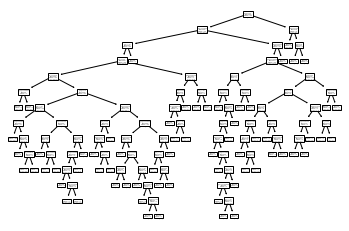

In [135]:
tree.plot_tree(d_tree)

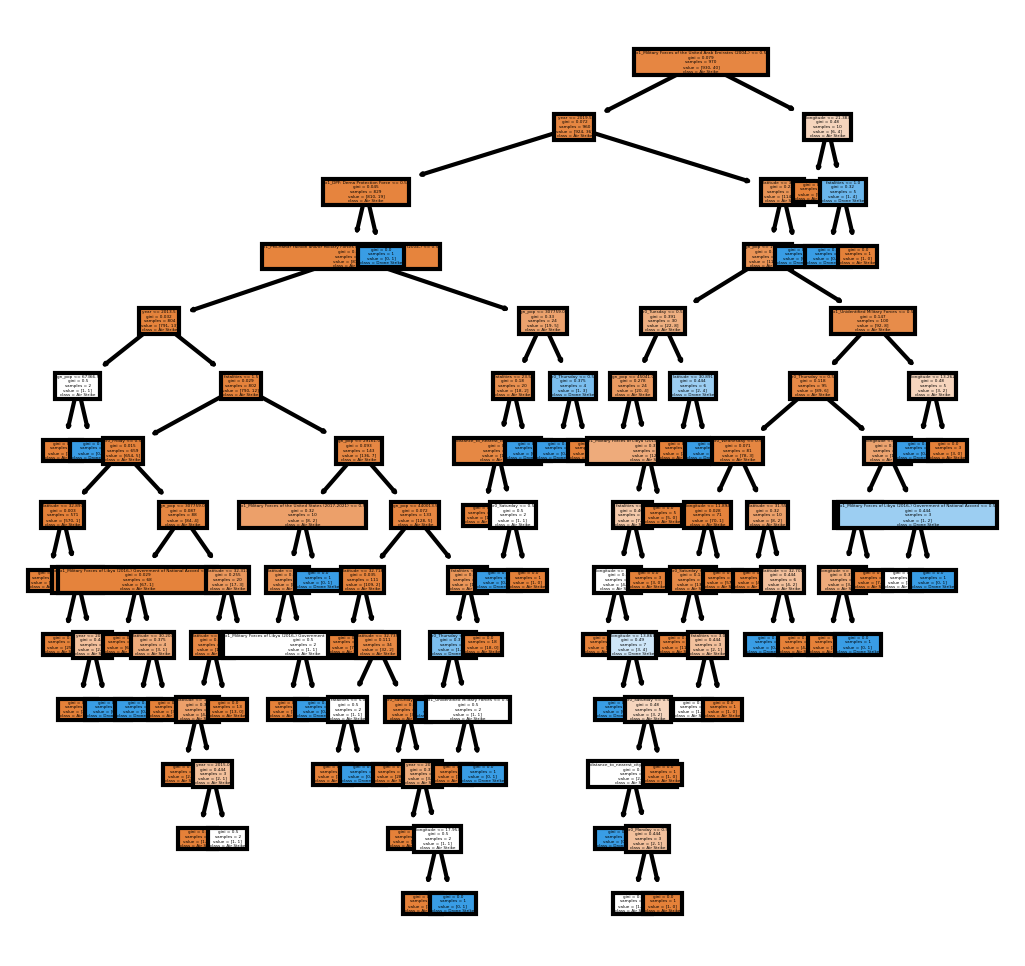

In [141]:
fn=feature_names
cn=['Air Strike', 'Drone Strike']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(d_tree,
               feature_names = fn, 
               class_names=cn,
               filled = True);

In [142]:
d_tree.score(X_train,y_train[:,1])

0.9958762886597938

In [144]:
tree_train_pred = cross_val_predict(d_tree, X_train, y_train[:,1], cv=3)
recall_score(y_train[:,1], tree_train_pred, average='micro')

0.9371134020618557

In [145]:
precision_score(y_train[:,1], tree_train_pred, average='micro')

0.9371134020618557

In [146]:
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(y_train[:,1], tree_train_pred)

array([[[  8,  32],
        [ 29, 901]],

       [[901,  29],
        [ 32,   8]]])

In [147]:
f1_score(y_train[:,1], tree_train_pred, average='weighted')

0.9359389717973312

In [148]:
y_train[:25,1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0.])

In [149]:
d_tree.predict(X_train[:25])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0.])

In [150]:
d_tree.predict_proba(X_train[:25])

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.]])

In [151]:
tree_train_pred = cross_val_predict(d_tree, X_train, y_train[:,1], cv=5)
print("F1 Score: ",f1_score(y_train[:,1], tree_train_pred, average='weighted'))
print("recall Score: ",recall_score(y_train[:,1], tree_train_pred, average='weighted'))
print("precision Score: ",precision_score(y_train[:,1], tree_train_pred, average='weighted'))

F1 Score:  0.9382986934230112
recall Score:  0.9422680412371134
precision Score:  0.9347261826423924


In [152]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [153]:
#X_train, y_train = make_classification(n_samples=1000, n_features=4, n_informative=2, n_redundant=0, random_state=0, shuffle=False)

rf_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,n_jobs=1)

rf_clf.fit(X_train,y_train[:,1])

RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=1)

In [154]:
y_train[:25,1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0.])

In [155]:
rf_clf.predict(X_train[:25])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0.])

In [156]:
rf_train_pred = cross_val_predict(rf_clf, X_train, y_train[:,1], cv=3)
print("F1 Score: ",f1_score(y_train[:,1], rf_train_pred, average='weighted'))
print("recall Score: ",recall_score(y_train[:,1], rf_train_pred, average='weighted'))
print("precision Score: ",precision_score(y_train[:,1], rf_train_pred, average='weighted'))

F1 Score:  0.9410842200472622
recall Score:  0.9597938144329897
precision Score:  0.9614120200440458


In [157]:
multilabel_confusion_matrix(y_train[:,1], rf_train_pred)

array([[[  1,  39],
        [  0, 930]],

       [[930,   0],
        [ 39,   1]]])

In [158]:
importances = rf_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_clf.estimators_], axis=0)

<AxesSubplot:>

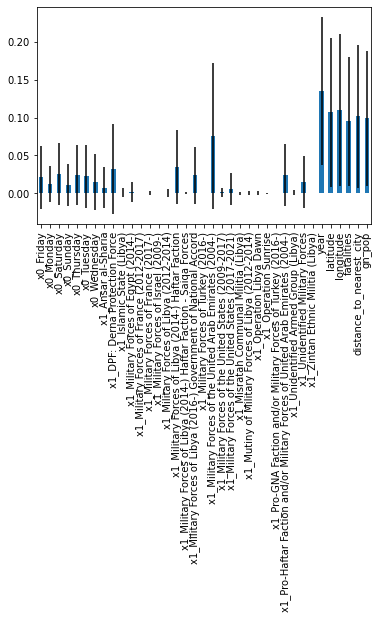

In [159]:
forest_importances = pd.Series(importances,index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)

In [160]:
for name, score in zip(feature_names,importances):
    print(name, score)

x0_Friday 0.021060152211867744
x0_Monday 0.01203384369666608
x0_Saturday 0.025070155298587693
x0_Sunday 0.010504723231639406
x0_Thursday 0.024637485053042862
x0_Tuesday 0.022157030863084917
x0_Wednesday 0.01516769135078588
x1_Ansar al-Sharia 0.0072011634521699005
x1_DPF: Derna Protection Force 0.03191290836080596
x1_Islamic State (Libya) 0.0007289482161277443
x1_Military Forces of Egypt (2014-) 0.0019172625850452055
x1_Military Forces of France (2012-2017) 0.0
x1_Military Forces of France (2017-) 0.00011795557691900313
x1_Military Forces of Israel (2009-) 6.4422605249000365e-06
x1_Military Forces of Libya (2012-2014) 0.000586920927825109
x1_Military Forces of Libya (2014-) Haftar Faction 0.034255592530003605
x1_Military Forces of Libya (2014-) Haftar Faction - Saiqa Forces 0.00013656938654203074
x1_Military Forces of Libya (2016-) Government of National Accord 0.023623802947634148
x1_Military Forces of Turkey (2016-) 0.0
x1_Military Forces of the United Arab Emirates (2004-) 0.07523615

In [ ]:
i_tree = 0
for tree_in_forest in rf_clf.estimators_:
    if (i_tree < 1):
        fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
        tree.plot_tree(tree_in_forest,
               feature_names = fn, 
               class_names=cn,
               filled = True);
    i_tree = i_tree + 1